<a href="https://colab.research.google.com/github/mcpinto1993/Kaggle_StoreSales/blob/main/StoreSalesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📝Store Sales Analysis⏳ Time Serie**

### **Load Data From Kaggle**

In [1]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download store-sales-time-series-forecasting

! unzip store-sales-time-series-forecasting.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 23% 5.00M/21.4M [00:00<00:00, 22.4MB/s]
100% 21.4M/21.4M [00:00<00:00, 69.7MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


### **Read Data**

In [2]:
import pandas as pd

In [3]:
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv')
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')

### **Stores Analysis**

In [ ]:
print("Column Types:\n{} \n".format(stores.dtypes))
print("DataFrame statistics: \n {} \n".format(stores.describe()))
print("Null Values: \n{} \n".format(stores.isnull().sum()))
print("Unique Values: \n{}".format(stores.nunique()))

In [5]:
#Total Nr of Stores -- 54
Total_NrStores = len(stores['store_nbr'].unique())

#Nr Of Stores By City, State and Type
NrStoresByCity = stores['city'].value_counts()
NrStoresByState = stores['state'].value_counts()
NrStoresByType = stores['type'].value_counts()

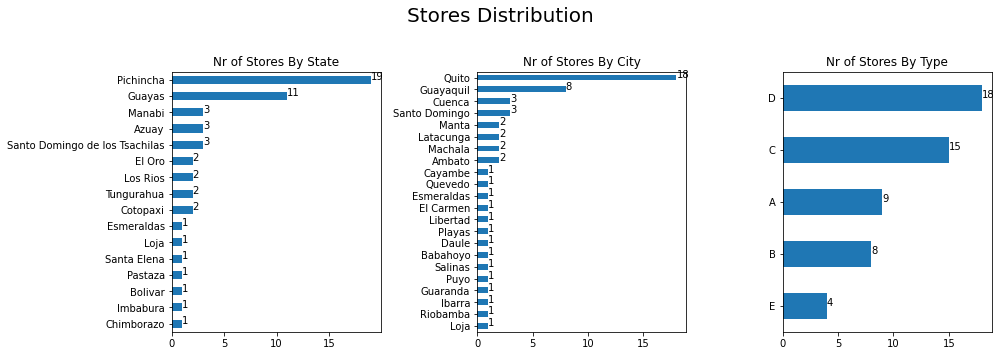

In [102]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.subplot(1,3,1)
NrStoresByState.sort_values().plot(kind='barh', figsize = (14,5), edgecolor = 'none')
plt.title("Nr of Stores By State")
for index, value in enumerate(NrStoresByState.sort_values()):
    plt.text(value, index,
             str(value))

plt.subplot(1,3,2)
NrStoresByCity.sort_values().plot(kind='barh', figsize = (14,5))
plt.title("Nr of Stores By City")
for index, value in enumerate(NrStoresByCity.sort_values()):
    plt.text(value, index,
             str(value))

plt.subplot(1,3,3)
NrStoresByType.sort_values().plot(kind='barh', figsize = (14,5))
plt.title("Nr of Stores By Type")
for index, value in enumerate(NrStoresByType.sort_values()):
    plt.text(value, index,
             str(value))

plt.tight_layout()
fig.suptitle("Stores Distribution", fontsize=20)
fig.subplots_adjust(hspace=0.4, top=0.8)
plt.show()

### **Transactions**

In [ ]:
print("Column Types:\n{} \n".format(transactions.dtypes))
print("DataFrame statistics: \n {} \n".format(transactions.describe()))
print("Null Values: \n{} \n".format(transactions.isnull().sum()))
print("Unique Values: \n{}".format(transactions.nunique()))

In [90]:
import datetime as dt

#Nr Of Transactions By Store
NrTransByStore = transactions[['store_nbr', 'transactions']].groupby(['store_nbr']).sum().sort_values(by='transactions', ascending = False).reset_index()

#Nr Of Transactions By Year, Month, DayOftheWeek
transactions['Year'] = pd.to_datetime(transactions['date']).dt.year
transactions['Month'] = pd.to_datetime(transactions['date']).dt.strftime('%b')
transactions['WeekDay'] = pd.to_datetime(transactions['date']).dt.strftime('%a')

Text(0.5, 1.0, 'Transactions By Store')

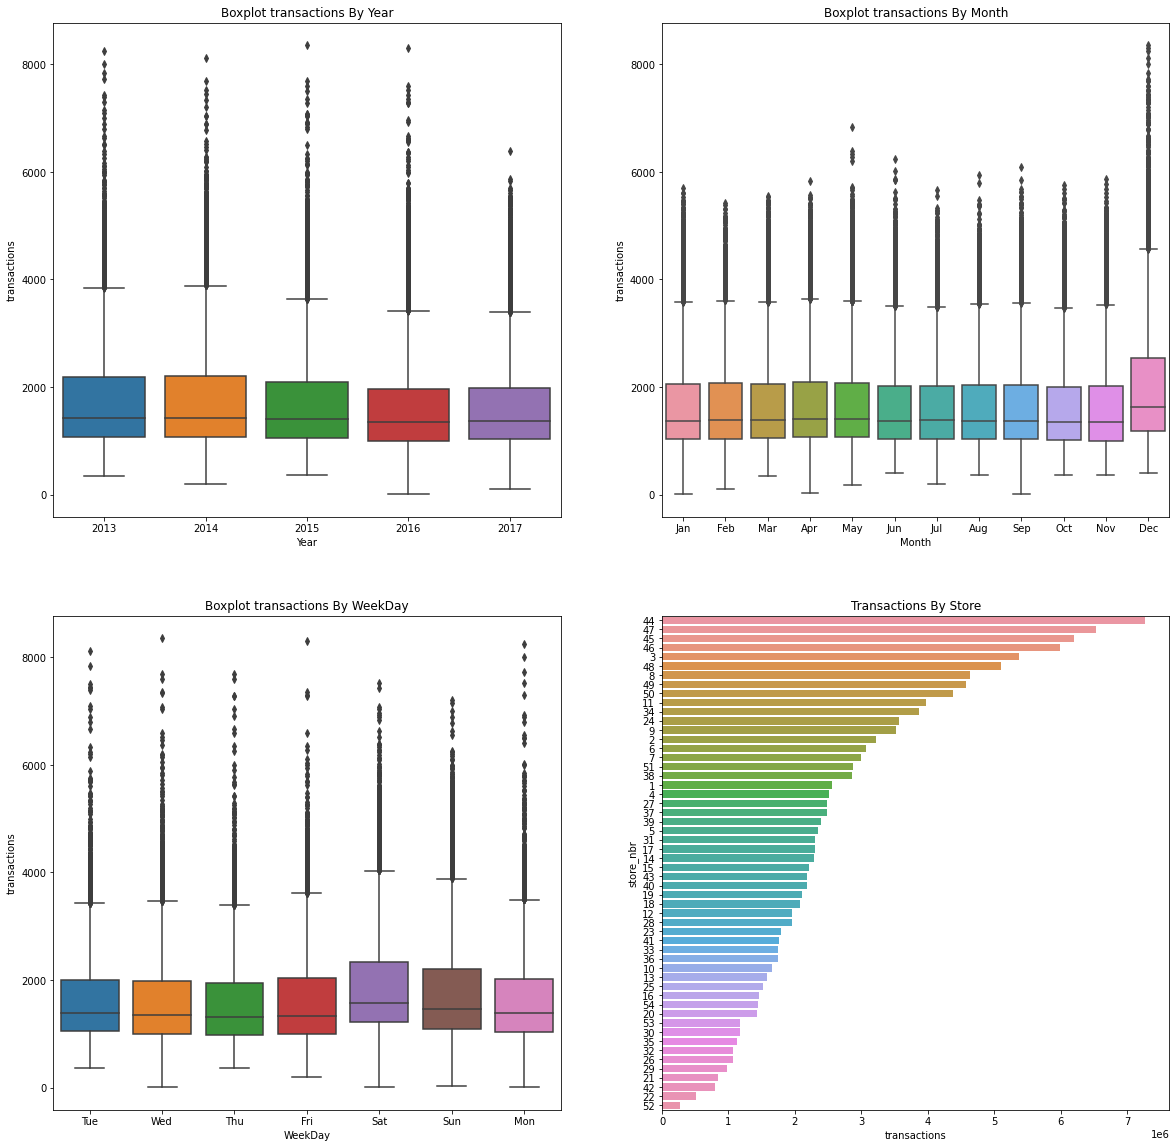

In [98]:
import seaborn as sns

fig = plt.figure(figsize=(20, 20))

#Subplot 1
ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.boxplot(y=transactions['transactions'], x=transactions['Year'])
ax1.set_title('Boxplot transactions By Year')

#Subplot 2
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.boxplot(y=transactions['transactions'], x=transactions['Month'])
ax2.set_title('Boxplot transactions By Month')

#Subplot 3
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.boxplot(y=transactions['transactions'], x=transactions['WeekDay'])
ax3.set_title('Boxplot transactions By WeekDay')

#Subplot 4
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.barplot(x=NrTransByStore['transactions'], y=NrTransByStore['store_nbr'], orient='h', order=NrTransByStore.sort_values(by='transactions', ascending = False).store_nbr)
ax4.set_title('Transactions By Store')